# **DESARROLLO CASO 6 CLASIFICACIÓN: MODALIDAD DE PRÉSTAMOS EN LÍNEA P2P**

- David Betancur Ramirez.
- Brayan Camilo Estrada Ramos.
- Pablo Mesa Hernández.
- Pedro Pablo Sánchez Castillo.

## 1. Entendimiento del Negocio
Una empresa de préstamos P2P requiere saber si un usuario incumplirá su préstamo o no, como parte de su proceso de calificación de riesgos. Esto en vista de que en dicha modalidad de préstamos en línea no hay entrevista en persona y un prestatario con simplemente rellenar un formulario en línea puede obtener la aprobación de su préstamo, siendo la información proporcionada por el prestatario propensa a la exageración y la distorsión.

## 2. Enfoque Analítico
Desarrollar un modelo de clasificación que permitar determinar si un usuario incumplirá su préstamo o no dentro de la modalidad de préstamos en línea P2P, con un nivel de desempeño superior al 85%.

## 3. Requerimiento de Datos
- Datos asociados al préstamo.
- Datos sobre el prestatario.

## 4. Recolección de Datos

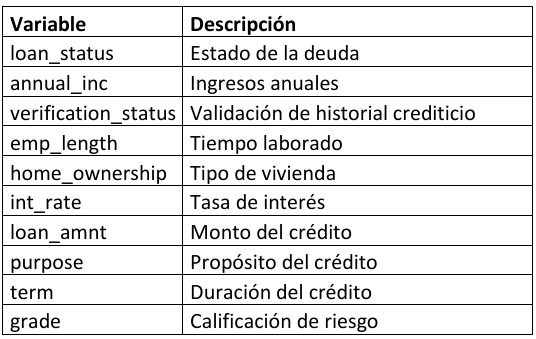

In [102]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

##Importación de los datos
data = pd.read_csv('datos_caso_6.csv')
data

,loan_status,annual_inc,verification_status,emp_length,home_ownership,int_rate,loan_amnt,purpose,term,grade
0,Fully Paid,24000.0,Verified,10+ years,RENT,10.65%,5000,credit_card,36 months,B
1,Charged Off,30000.0,Source Verified,< 1 year,RENT,15.27%,2500,car,60 months,C
2,Fully Paid,12252.0,Not Verified,10+ years,RENT,15.96%,2400,small_business,36 months,C
3,Fully Paid,49200.0,Source Verified,10+ years,RENT,13.49%,10000,other,36 months,C
4,Fully Paid,80000.0,Source Verified,1 year,RENT,12.69%,3000,other,60 months,B
...,...,...,...,...,...,...,...,...,...,...
38700,Fully Paid,110000.0,Not Verified,4 years,MORTGAGE,8.07%,2500,home_improvement,36 months,A
38701,Fully Paid,18000.0,Not Verified,3 years,RENT,10.28%,8500,credit_card,36 months,C
38702,Fully Paid,100000.0,Not Verified,< 1 year,MORTGAGE,8.07%,5000,debt_consolidation,36 months,A
38703,Fully Paid,200000.0,Not Verified,< 1 year,MORTGAGE,7.43%,5000,other,36 months,A


## 5. Entendimiento de los datos
- Verificación de datos nulos.
- Estadísticas univariada, bivariada y multivariada.
- Validación desbalance de y.

In [103]:
import matplotlib.pyplot as plt
import seaborn as sb

In [104]:
#Identificación de datos nulos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38705 entries, 0 to 38704
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_status          38705 non-null  object 
 1   annual_inc           38705 non-null  float64
 2   verification_status  38705 non-null  object 
 3   emp_length           38705 non-null  object 
 4   home_ownership       38705 non-null  object 
 5   int_rate             38705 non-null  object 
 6   loan_amnt            38705 non-null  int64  
 7   purpose              38705 non-null  object 
 8   term                 38705 non-null  object 
 9   grade                38705 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.0+ MB


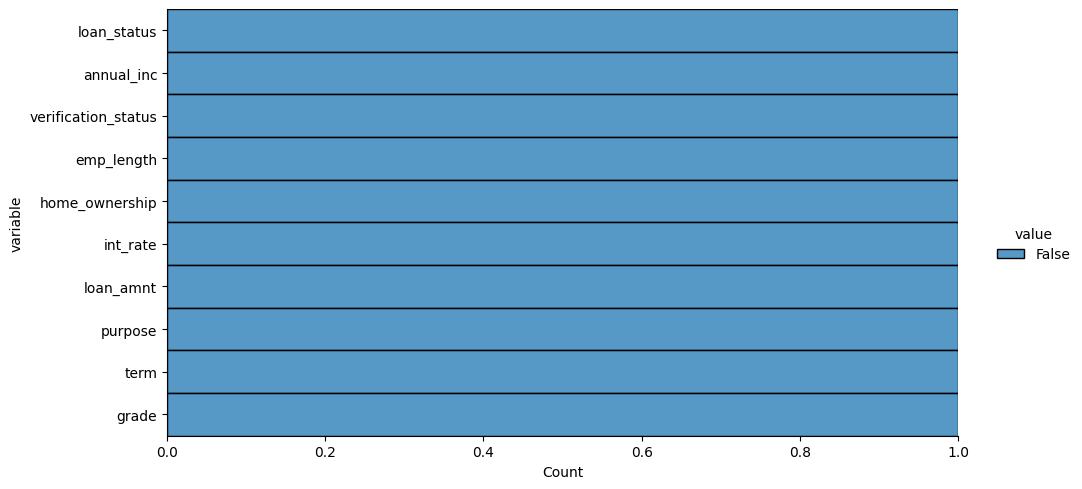

In [105]:
#Visualizar la proporción de datos nulos por variable
data.isnull().melt().pipe(lambda df: sb.displot(data = df, y = 'variable', hue = 'value', multiple = 'fill', aspect = 2))
plt.show()

Las variables del conjunto de datos a trabajar no presentan valores nulos, por lo cual no es necesario realizar un tratamiento de los mismos.

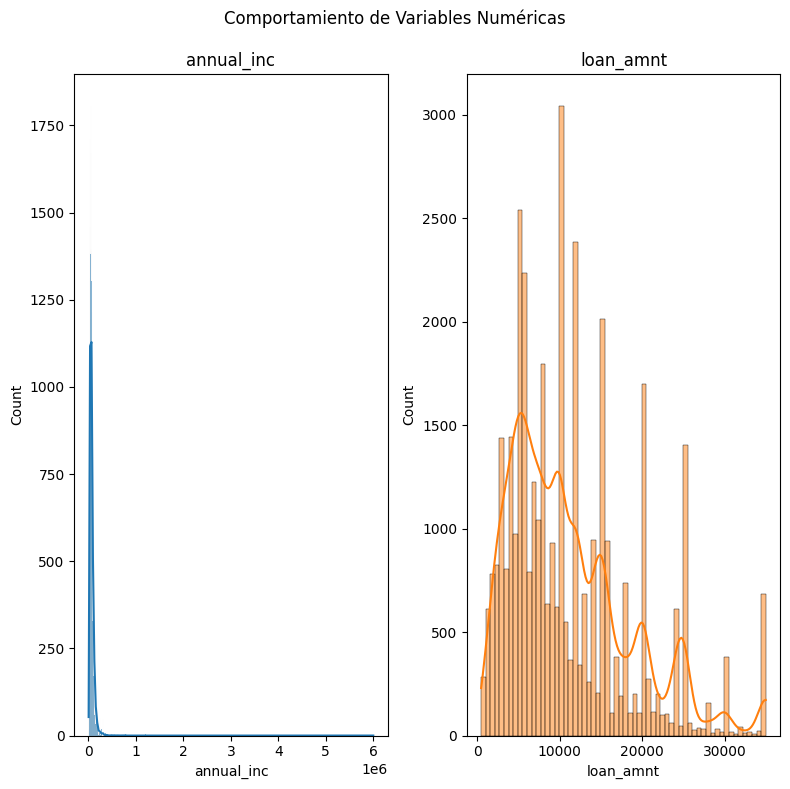

In [106]:
#Exploración univariada de los datos
##Para datos numéricos: histogramas de frecuencia
##Para datos categóricos: gráficos de torta

###HISTOGRAMAS DE FRECUENCIA
fig, ax = plt.subplots(1, 2, figsize = (8, 8))
ax = ax.flat
num_col = data.select_dtypes(include = ['int64', 'float64']).columns
for i, col in enumerate(num_col):
    sb.histplot(data = data, x = col, 
                kde = True, color = (list(plt.rcParams['axes.prop_cycle']) * 7)[i]['color'], ax = ax[i])
    ax[i].set_title(col)
fig.tight_layout()
fig.subplots_adjust(top = 0.9)
fig.suptitle('Comportamiento de Variables Numéricas')
plt.show()

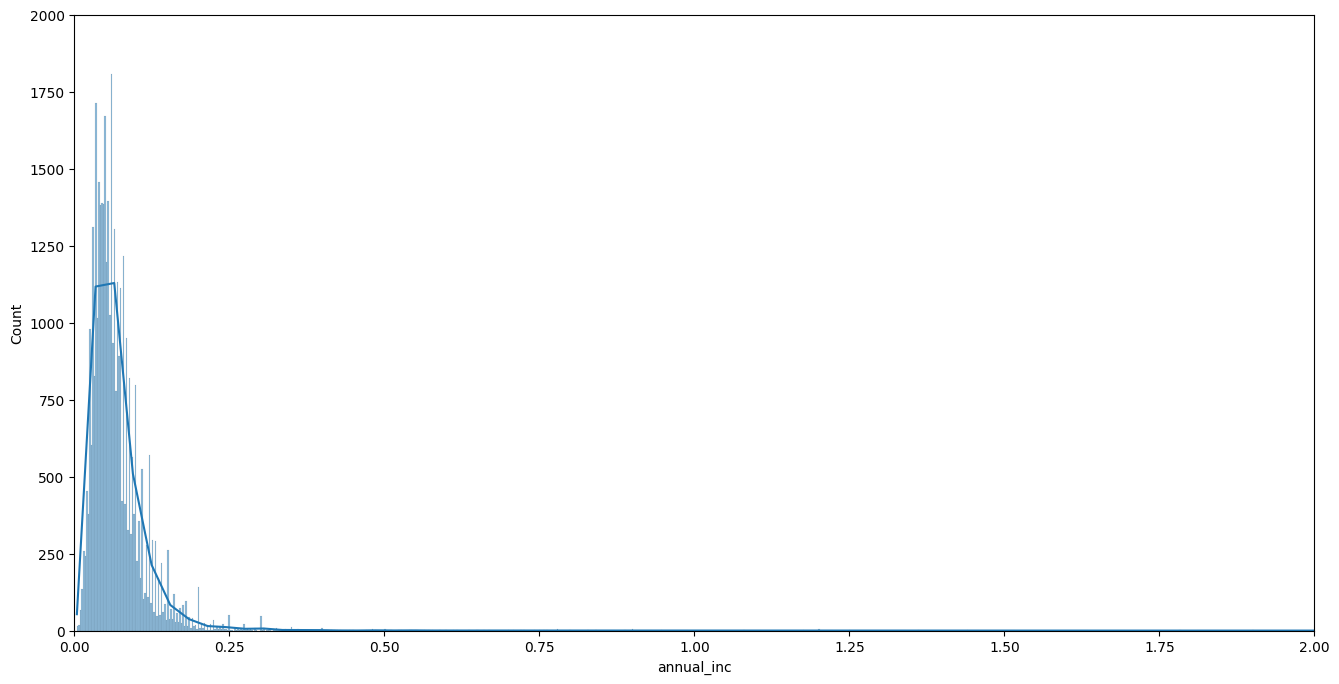

In [107]:
fig, ax = plt.subplots(figsize=(16, 8))
sb.histplot(data=data, x=data["annual_inc"] / 1e6, kde=True, ax=ax)
plt.ylim(0, 2000)
plt.xlim(0, 2)
ax.set_xlabel("annual_inc")
plt.show()

In [108]:
data['annual_inc'].sort_values(ascending=False).head(n=20)

29172    6000000.0
28719    3900000.0
38080    2039784.0
22797    1900000.0
7011     1782000.0
32973    1440000.0
33295    1362000.0
10275    1250000.0
23392    1200000.0
20726    1200000.0
24935    1200000.0
32423    1200000.0
26704    1176000.0
28008    1080000.0
20694     948000.0
24990     900000.0
33288     900000.0
7289      900000.0
33175     900000.0
24358     889000.0
Name: annual_inc, dtype: float64

Dentro de los registros de la variable, se encuentran dos valores que están muy alejados al comportamiento típico de los demás; es decir, por encima de los 2 millones.

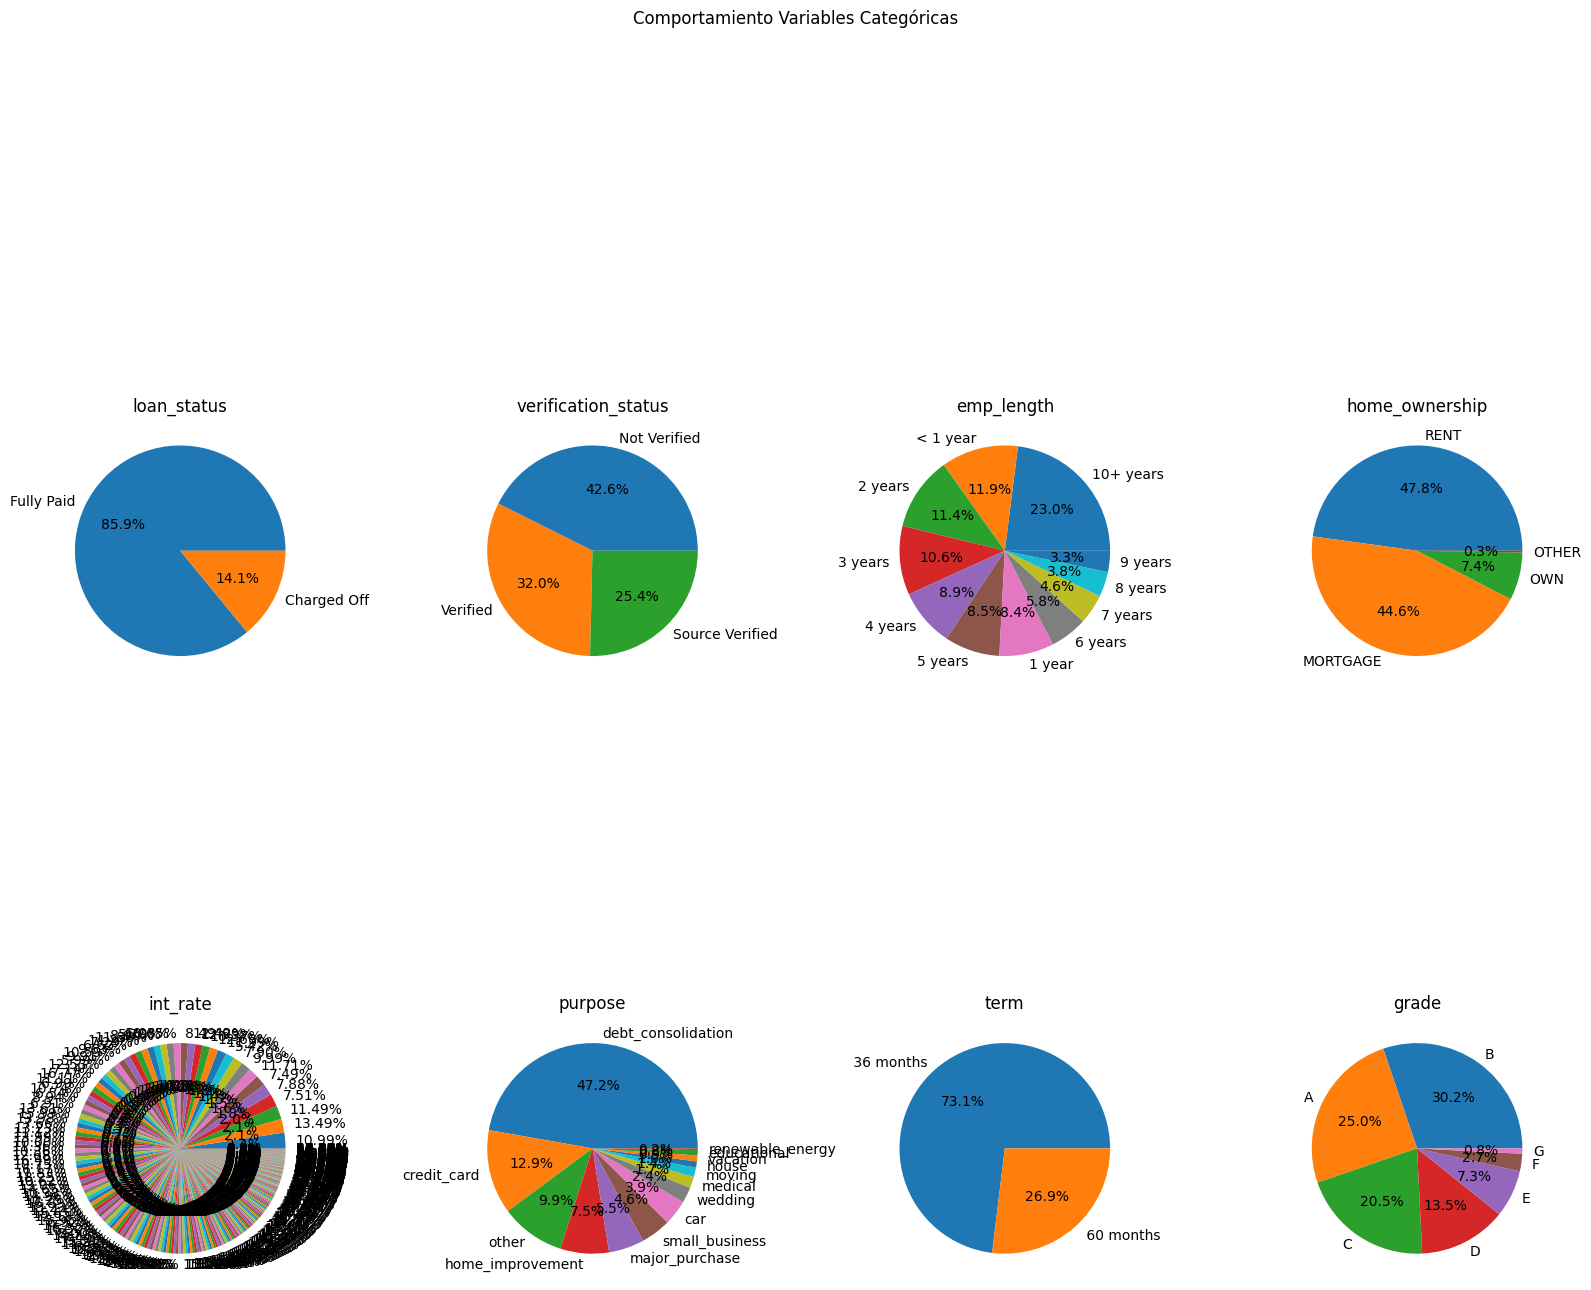

In [109]:
##GRÁFICOS DE TORTA
fig, ax = plt.subplots(2, 4, figsize = (16, 16))
ax = ax.flat
cat_col = data.select_dtypes(include = ['object']).columns
for i, col in enumerate(cat_col):
    ax[i].pie(x = data[col].value_counts(), labels = data[col].value_counts().index, autopct = '%0.1f%%')
    ax[i].set_title(col)
fig.tight_layout()
fig.subplots_adjust(top = 0.9)
fig.suptitle("Comportamiento Variables Categóricas")
plt.show()

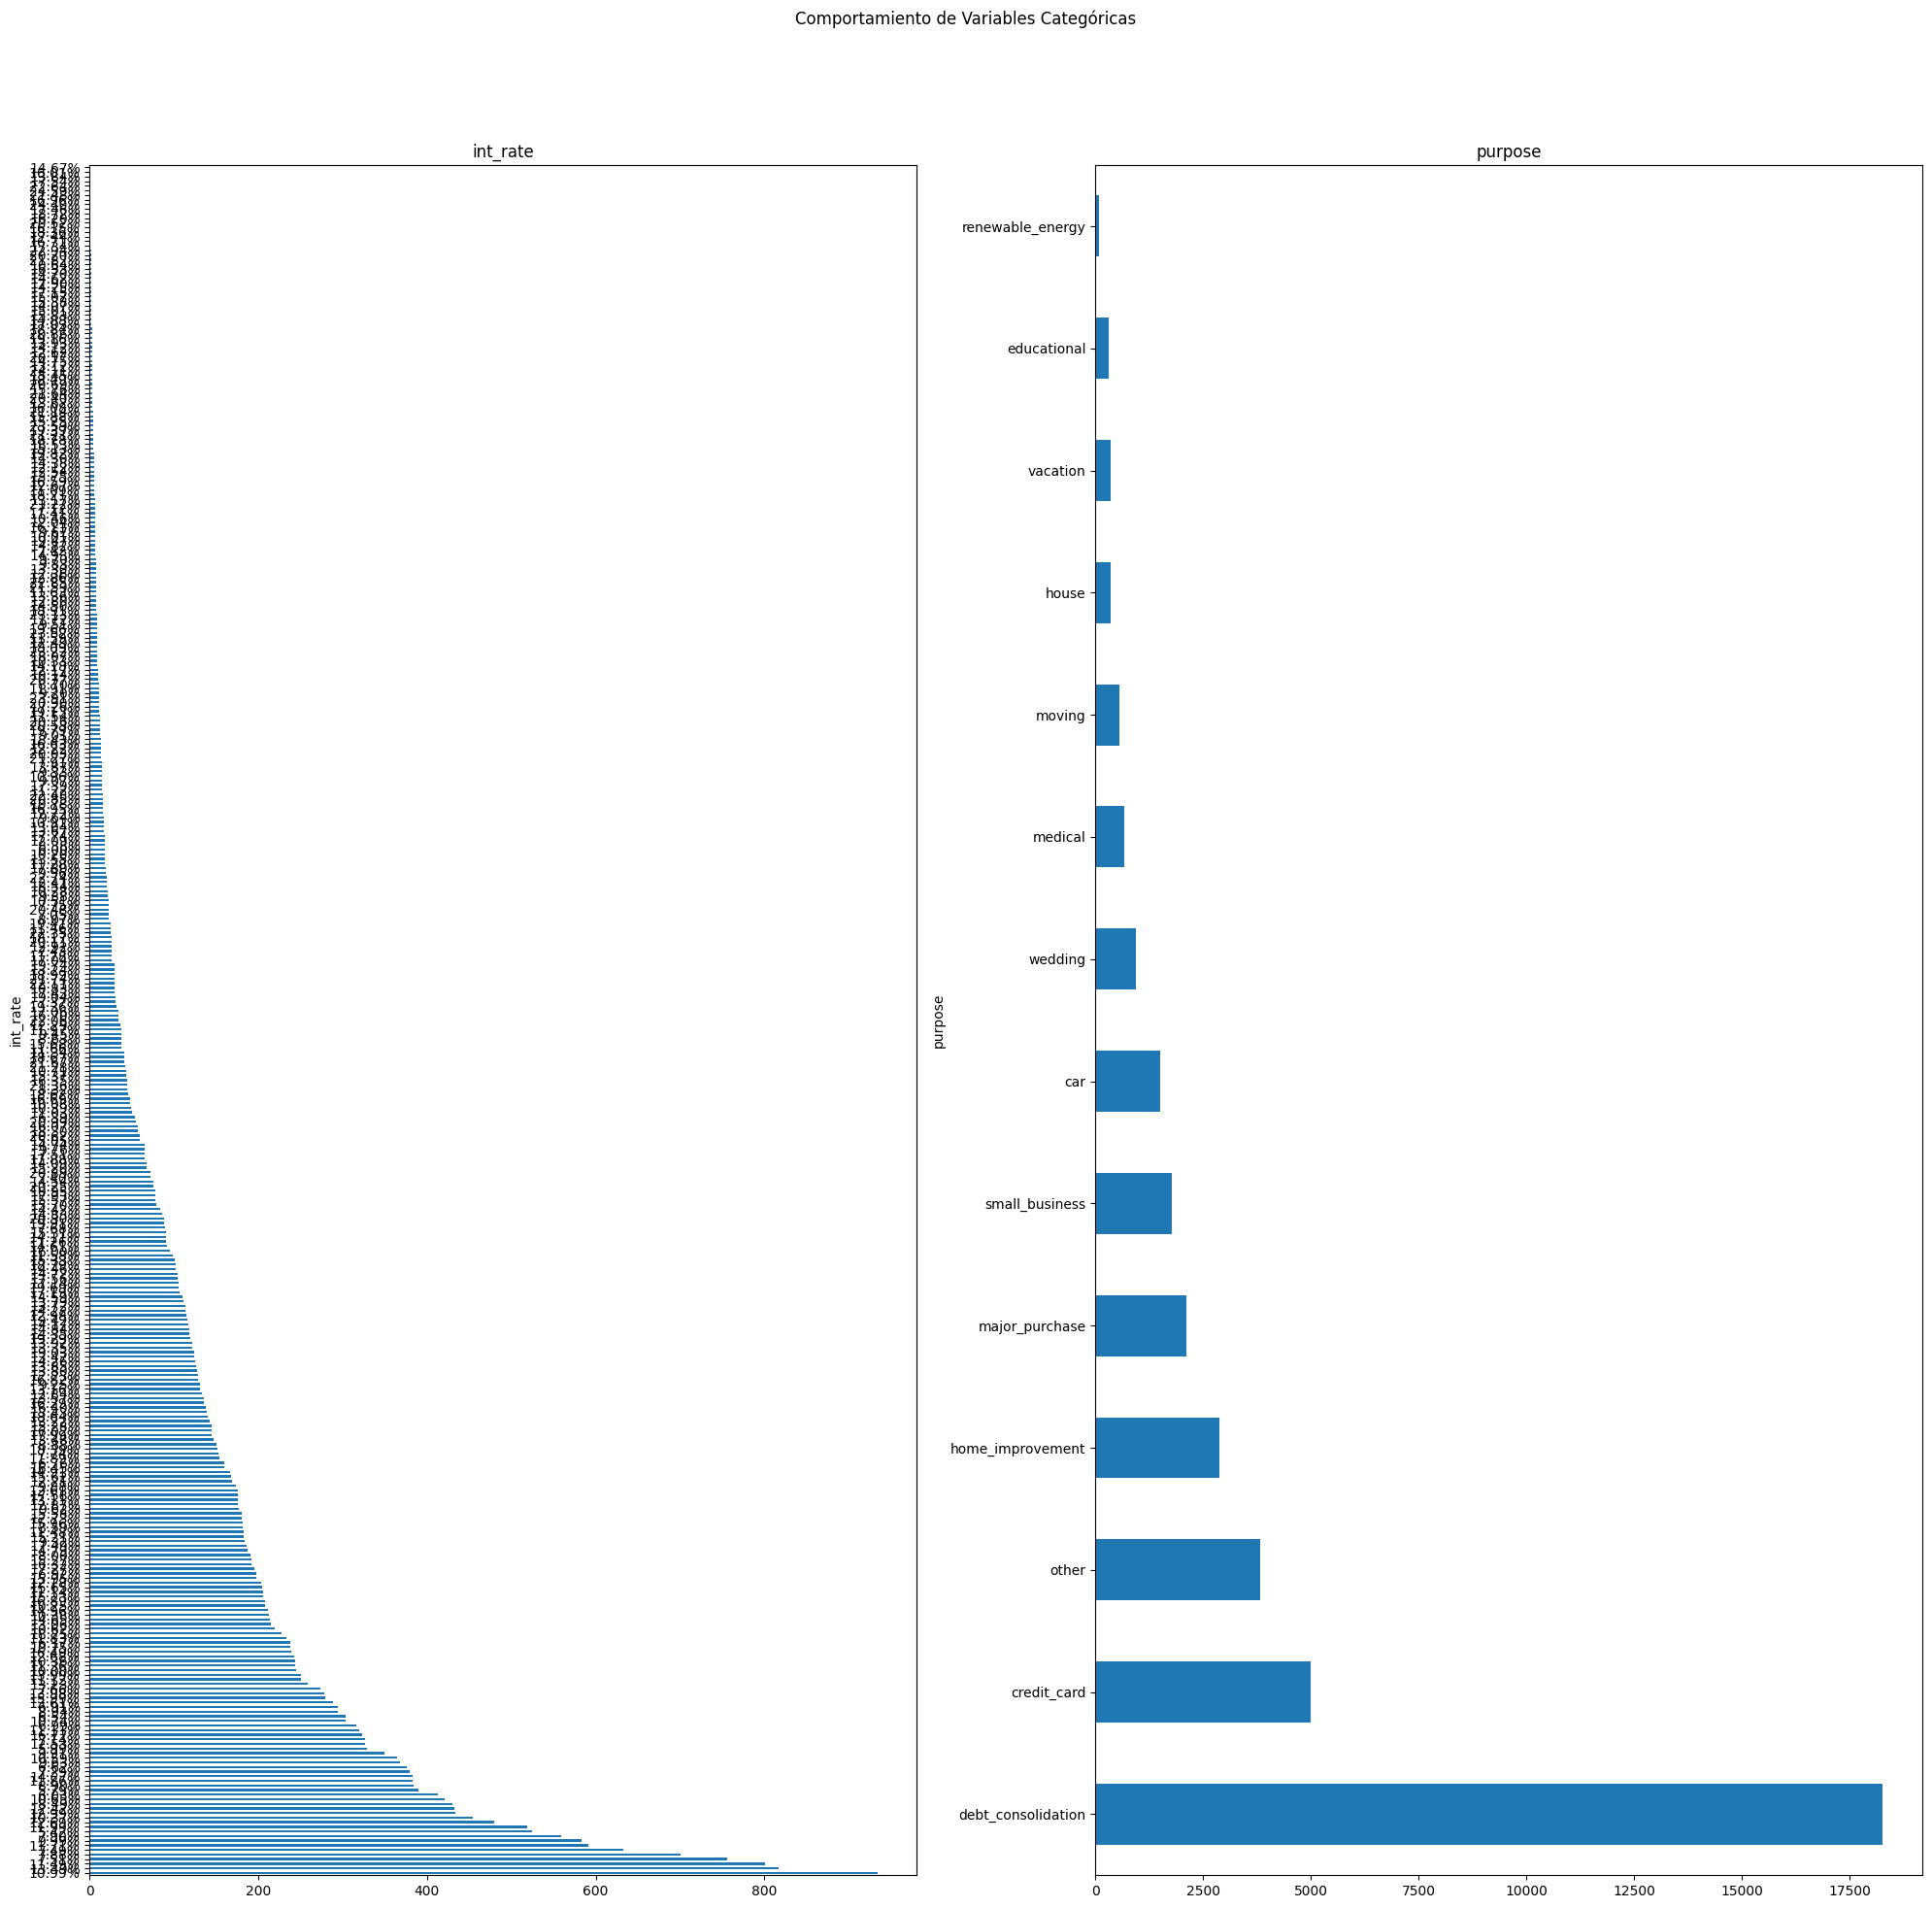

In [110]:
##Gráfico de barras para variables categóricas
fig, ax = plt.subplots(1, 2, figsize = (20, 20))
ax = ax.flat

col = data[['int_rate', 'purpose']]
for i, col in enumerate(col):
    data[col].value_counts().plot.barh(ax = ax[i])
    ax[i].set_title(col)

fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Comportamiento de Variables Categóricas')
plt.show()

## 6. Preparación de los Datos

- Eliminar variables que no son significativas.
- Balancear Y.
- Separar en conjuntos de entrenamiento y prueba.
- Transformar los datos para que sean usables por el modelo.

In [111]:
data_mod = data.drop(columns = ['int_rate'], axis=1)
data_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38705 entries, 0 to 38704
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_status          38705 non-null  object 
 1   annual_inc           38705 non-null  float64
 2   verification_status  38705 non-null  object 
 3   emp_length           38705 non-null  object 
 4   home_ownership       38705 non-null  object 
 5   loan_amnt            38705 non-null  int64  
 6   purpose              38705 non-null  object 
 7   term                 38705 non-null  object 
 8   grade                38705 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 2.7+ MB


### Balanceo de Objetivo (Y)
- En nuestro caso, la variable objetivo corresponde a "grade"

In [112]:
data_a = data_mod[data_mod['grade'] == 'A'] 
data_b = data_mod[data_mod['grade'] == 'B']
data_c = data_mod[data_mod['grade'] == 'C']
data_d = data_mod[data_mod['grade'] == 'D'] 
data_e = data_mod[data_mod['grade'] == 'E']
data_f = data_mod[data_mod['grade'] == 'F']
data_g = data_mod[data_mod['grade'] == 'G'] 

print(f'El tamaño de la clase a es: {data_a.shape}')
print(f'El tamaño de la clase b es: {data_b.shape}')
print(f'El tamaño de la clase c es: {data_c.shape}')
print(f'El tamaño de la clase d es: {data_d.shape}')
print(f'El tamaño de la clase e es: {data_e.shape}')
print(f'El tamaño de la clase f es: {data_f.shape}')
print(f'El tamaño de la clase g es: {data_g.shape}')

El tamaño de la clase a es: (9694, 9)
El tamaño de la clase b es: (11697, 9)
El tamaño de la clase c es: (7938, 9)
El tamaño de la clase d es: (5213, 9)
El tamaño de la clase e es: (2811, 9)
El tamaño de la clase f es: (1035, 9)
El tamaño de la clase g es: (317, 9)


In [113]:
# Unir las categorías 'E', 'F' y 'G' en una sola y renombrarla como 'X'
data_balanced = data_mod.copy()
data_balanced['grade'] = data_balanced['grade'].replace(['D', 'E', 'F', 'G'], 'X')
data_balanced['grade'].value_counts()

grade
B    11697
A     9694
X     9376
C     7938
Name: count, dtype: int64

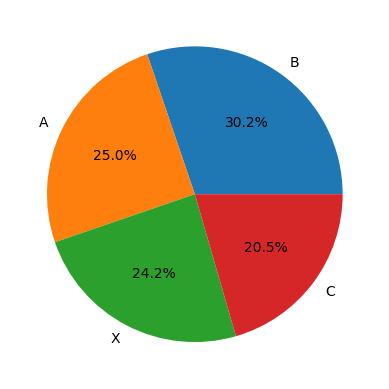

In [114]:
plt.pie(x = data_balanced.grade.value_counts(), labels= data_balanced.grade.value_counts().index, autopct='%0.1f%%')
plt.show()

In [115]:
X = data_balanced.drop('grade', axis=1)
y = data_balanced[['grade']]
print(f'El tamaño de X es: {X.shape} y el tamaño de y es: {y.shape}')

El tamaño de X es: (38705, 8) y el tamaño de y es: (38705, 1)


In [116]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline

num_col = X.select_dtypes(include= ['int64', 'float64']).columns.to_list()
cat_col = X.select_dtypes(include= ['object']).columns.to_list()
num_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])
cat_transformer = Pipeline(steps=[('encoder', OneHotEncoder(sparse_output=False))])
preprocessor = ColumnTransformer(transformers= [('num', num_transformer, num_col),
                                                ('cat', cat_transformer, cat_col)],
                                                remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['annual_inc', 'loan_amnt']),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(sparse_output=False))]),
                                 ['loan_status', 'verification_status',
                                  'emp_length', 'home_ownership', 'purpose',
                                  'term'])])

In [117]:
X_pre = preprocessor.fit_transform(X)
cod_cat = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(cat_col)
labels = np.concatenate([num_col, cod_cat])
X_pro = pd.DataFrame(X_pre, columns= labels)
X_pro.head(10)

,annual_inc,loan_amnt,loan_status_Charged Off,loan_status_Fully Paid,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,emp_length_1 year,emp_length_10+ years,emp_length_2 years,...,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
0,0.003336,0.130435,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.004336,0.057971,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.001376,0.055072,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.007538,0.275362,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.012675,0.072464,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.005337,0.130435,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
6,0.007172,0.188406,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,0.007338,0.072464,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,0.006004,0.147826,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
9,0.001835,0.141304,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### Separación en Datos de Entrenamiento y Prueba

In [118]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pro, y, train_size=0.7, random_state=123) 

print(f'El tamaño del conjunto de entrenamiento es: {X_train.shape} {y_train.shape}\nEl tamaño del conjunto de validación es: {X_test.shape} {y_test.shape}')

El tamaño del conjunto de entrenamiento es: (27093, 38) (27093, 1)
El tamaño del conjunto de validación es: (11612, 38) (11612, 1)


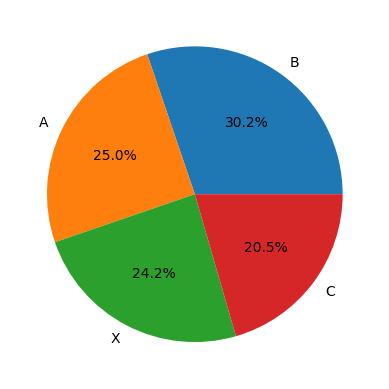

In [119]:
plt.pie(x = data_balanced.grade.value_counts(), labels= data_balanced.grade.value_counts().index, autopct='%0.1f%%')
plt.show()

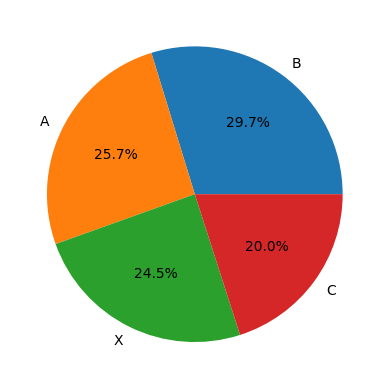

In [120]:
plt.pie(x = y_test.grade.value_counts(), labels = y_test.grade.value_counts().index, autopct= '%0.1f%%')
plt.show()

## **7. Modelado de Datos**

- Regresión Logística.
- K Vecinos más Cercanos.
- Máquina de Soporte Vectorial.
- Árboles de Decisión.
- Bosque Aleatorio.
- Adaptative Boosting.
- Gradient Boosting.
- RNA

In [121]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # Búsqueda exhaustiva y aleatorizada con validación cruzada

modelo_1 = LogisticRegression(solver= 'saga', random_state=123)
param_grid = {'penalty': ['l1', 'l2', 'elasticnet'], 'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
clf_1 = GridSearchCV(estimator= modelo_1, param_grid= param_grid, cv= 5, scoring= 'accuracy')
clf_1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(random_state=123, solver='saga'),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='accuracy')

In [122]:
validation = pd.concat([pd.DataFrame(clf_1.cv_results_['params']),
                        pd.DataFrame(clf_1.cv_results_['mean_test_score'], columns=['accuracy'])], axis=1)
validation.sort_values('accuracy', ascending= False)

,C,penalty,accuracy
9,0.1000,l1,0.414461
7,0.0100,l2,0.413243
10,0.1000,l2,0.413243
16,10.0000,l2,0.412172
12,1.0000,l1,0.412135
21,1000.0000,l1,0.412061
19,100.0000,l2,0.412061
22,1000.0000,l2,0.412061
15,10.0000,l1,0.412061
13,1.0000,l2,0.412061


In [123]:
modelo_1_final = clf_1.best_estimator_
modelo_1_final

LogisticRegression(C=0.1, penalty='l1', random_state=123, solver='saga')

Métricas de Desempeño en Entrenamiento
              precision    recall  f1-score   support

           A       0.43      0.57      0.49      6706
           B       0.35      0.47      0.40      8243
           C       0.30      0.01      0.01      5610
           X       0.50      0.55      0.52      6534

    accuracy                           0.42     27093
   macro avg       0.40      0.40      0.36     27093
weighted avg       0.40      0.42      0.37     27093



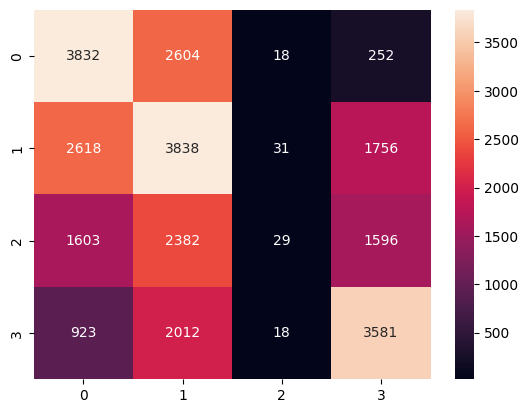

In [124]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred_1_train = modelo_1_final.predict(X_train)
print('Métricas de Desempeño en Entrenamiento')
print(classification_report(y_train, y_pred_1_train))
sb.heatmap(confusion_matrix(y_train, y_pred_1_train), annot= True, fmt= 'd')
plt.show()

## K Vecinos más cercanos

In [125]:
from sklearn.neighbors import KNeighborsClassifier # No tiene semilla aleatoria
modelo_2 = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7, 19, 21, 53], 'p': [1, 2]}
clf_2 = GridSearchCV(estimator= modelo_2, param_grid= param_grid, cv = 5, scoring= 'f1_weighted') # weighted para que sirva para multiclase
clf_2.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 19, 21, 53], 'p': [1, 2]},
             scoring='f1_weighted')

In [126]:
validation = pd.concat([pd.DataFrame(clf_2.cv_results_['params']),
                        pd.DataFrame(clf_2.cv_results_['mean_test_score'], columns=['f1'])], axis=1)
validation.sort_values('f1', ascending= False)

,n_neighbors,p,f1
11,53,2,0.374232
10,53,1,0.373744
8,21,1,0.373152
9,21,2,0.372164
7,19,2,0.371453
6,19,1,0.371246
4,7,1,0.354517
5,7,2,0.354166
2,5,1,0.349700
3,5,2,0.349368


In [127]:
modelo_2_final = clf_2.best_estimator_
modelo_2_final

KNeighborsClassifier(n_neighbors=53)

Metricas de Desempeño en Entrenamiento
              precision    recall  f1-score   support

           A       0.43      0.62      0.51      6706
           B       0.39      0.45      0.42      8243
           C       0.35      0.08      0.13      5610
           X       0.52      0.52      0.52      6534

    accuracy                           0.43     27093
   macro avg       0.42      0.42      0.40     27093
weighted avg       0.42      0.43      0.41     27093



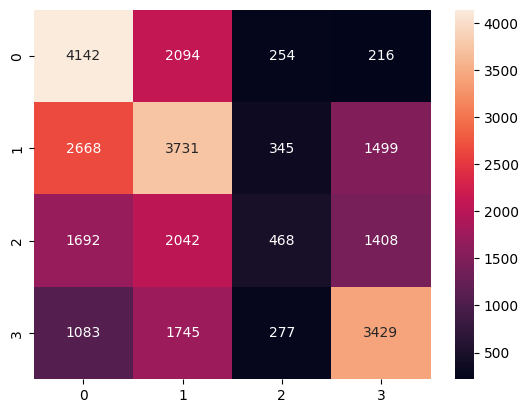

In [128]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred_1_train = modelo_2_final.predict(X_train)
print('Metricas de Desempeño en Entrenamiento')
print(classification_report(y_train, y_pred_1_train))
sb.heatmap(confusion_matrix(y_train, y_pred_1_train), annot= True, fmt= 'd')
plt.show()

Metricas de Desempeño en Prueba
              precision    recall  f1-score   support

           A       0.42      0.59      0.49      2988
           B       0.34      0.40      0.37      3454
           C       0.24      0.06      0.09      2328
           X       0.51      0.51      0.51      2842

    accuracy                           0.41     11612
   macro avg       0.38      0.39      0.37     11612
weighted avg       0.38      0.41      0.38     11612



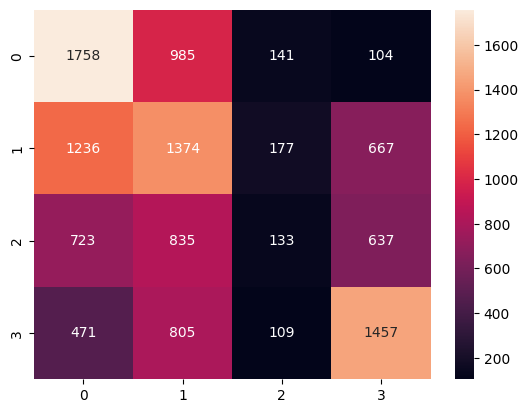

In [129]:
y_pred_1_test = modelo_2_final.predict(X_test)
print('Metricas de Desempeño en Prueba')
print(classification_report(y_test, y_pred_1_test))
sb.heatmap(confusion_matrix(y_test, y_pred_1_test), annot= True, fmt= 'd')
plt.show()